In [577]:
import math
import random
import sqlite3
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

In [578]:
%matplotlib inline

# Init db 

In [579]:
conn = sqlite3.connect(':memory:')
c = conn.cursor()

In [580]:
c.execute('''DROP TABLE users''')

OperationalError: no such table: users

In [581]:
c.execute('''DROP TABLE queue''')

OperationalError: no such table: queue

In [582]:
c.execute('''CREATE TABLE users
             (id integer primary key, rating integer, skill integer, rd real, win integer, lose integer, draw integer)''')

In [583]:
c.execute('''CREATE TABLE queue
             (id integer primary key, rating integer, skill integer, rd real, win integer, lose integer, draw integer)''')

# Generate Users 

In [584]:
mu = 1500
sigma = 400
size = 10000
skills = np.random.normal(mu, sigma, size)

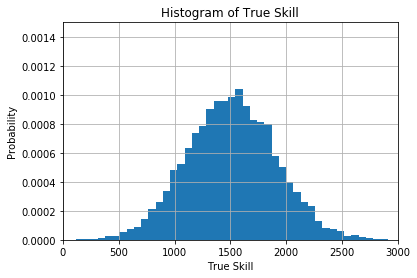

In [585]:
plt.hist(skills, 50, density=30)
plt.xlabel('True Skill')
plt.ylabel('Probability')
plt.title('Histogram of True Skill')
plt.axis([0, 3000, 0, 0.0015])
plt.grid(True)
plt.show()

In [586]:
raw_users = np.array([
    [
        _id,
        max(10, int(skill)),
        mu,
        350.0
    ]
    for _id, skill in zip(range(1, size+1), skills)
])
raw_users[:5]

array([[1.000e+00, 2.073e+03, 1.500e+03, 3.500e+02],
       [2.000e+00, 1.567e+03, 1.500e+03, 3.500e+02],
       [3.000e+00, 1.748e+03, 1.500e+03, 3.500e+02],
       [4.000e+00, 1.645e+03, 1.500e+03, 3.500e+02],
       [5.000e+00, 1.075e+03, 1.500e+03, 3.500e+02]])

# Match Functions

In [587]:
def init(users):
    c.execute("DELETE FROM users")
    conn.commit()
    c.execute("DELETE FROM queue")
    conn.commit()
    
    c.executemany("INSERT INTO users (id, skill, rating, rd, win, lose, draw) VALUES (?, ?, ?, ?, 0, 0, 0)", users)
    conn.commit()

In [588]:
def enqueue(size=3000):
    c.execute("DELETE FROM queue")
    conn.commit()
    
    c.execute("SELECT id, skill, rating, rd, win, lose, draw FROM users ORDER BY rating")
    users = c.fetchall()
    c.executemany("INSERT INTO queue (id, skill, rating, rd, win, lose, draw) VALUES (?, ?, ?, ?, ?, ?, ?)", random.sample(users, size))
    conn.commit()

In [589]:
def matchmake(match_size=8, gap=200):
    matches = []
    run_count = 0
    while True:
        run_count += 1
        c.execute("SELECT id, skill, rating, rd, win, lose, draw FROM queue ORDER BY rating LIMIT 1")
        entry = c.fetchone()
        if not entry:
            break
        else:
            c.execute("DELETE FROM queue WHERE id = ?", (entry[0],))
            conn.commit()
        
        if run_count % 1000 == 0:
            print('run: ', run_count)

        match_found = False
        candies = [entry]
        
        c.execute("SELECT id, skill, rating, rd, win, lose, draw FROM queue WHERE rating <= ? AND rating >= ? ORDER BY rating LIMIT 50", (entry[2]+gap, entry[2]-gap))
        entries = list(c.fetchall())
        random.shuffle(entries)
        
        for idx, candi in enumerate(entries):
            candies.append(candi)
                
            if len(candies) == match_size:
                matches.append(candies)
                match_found = True
                for el in candies:
                    c.execute("DELETE FROM queue WHERE id = ?", (el[0],))
                    conn.commit()
                break
                
        if not match_found:
            print('not found match')
            print(candies)

    c.execute("DELETE FROM queue")
    conn.commit()

    return matches

In [590]:
def display():
    c.execute('SELECT id, skill, rating, win, lose, draw FROM users ORDER BY rating')
    res = np.array(sorted(list(c.fetchall()), key=lambda x: x[0]))
    pprint(res[-10:])
    
    user_ids = res[:, 0]
    user_skills = res[:, 1]
    user_ratings = res[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line = [min(user_skills), max(user_skills)]
    ax.plot(line, line, '--')
    ax.set_ylim([min(user_ratings)-100, max(user_ratings)+100])
    fig.tight_layout()

    plt.scatter(x=user_skills, y=user_ratings, color='g')
    plt.ylabel('rating')
    plt.xlabel('strength')
    plt.show()

# ELO

In [591]:
def get_score(teamA, teamB):
    momentum = 50
    
    probA = np.random.randint(low=0, high=np.mean(teamA[:, 1]), size=momentum)
    probB = np.random.randint(low=0, high=np.mean(teamB[:, 1]), size=momentum)
    
    W = 0
    D = 0
    L = 0
    for pa, pb in zip(probA, probB):
        if pa > pb:
            W += 1
        elif pa == pb:
            D += 1
        else:
            L += 1
    
    if W > L:
        return 1
    elif W == L:
        return 0.5
    else:
        return 0

In [592]:
1 / (1 + 10 ** ((1994-1706)/400))

0.16004930536524656

In [618]:
def match_elo(teamA, teamB):
    K = 32*4
    
    Ra = np.average(teamA[:, 2])
    Rb = np.average(teamB[:, 2])

    Sa = get_score(teamA, teamB)
    Sb = 1 - Sa

    Ea = 1 / (1 + 10 ** ((Rb-Ra)/400))
    Eb = 1 / (1 + 10 ** ((Ra-Rb)/400))

    return Sa, Sb, int(K*(Sa-Ea)), int(K*(Sb-Eb))

In [619]:
def match_and_update_ratings_elo(rounds):
    for i in range(rounds):
        print('epoch: ', i)
        enqueue()
        matches = matchmake()
        for users in matches:
            teamA = np.array(users[:4])
            teamB = np.array(users[4:])
            
            Sa, Sb, delta_Ra, delta_Rb = match_elo(teamA, teamB)

            for userA in teamA:
                Ra = int(userA[2] + (delta_Ra / 4))
                aWin = userA[4] + 1 if Sa == 1 else userA[4]
                aLose = userA[5] + 1 if Sa == 0 else userA[5]
                aDraw = userA[6] + 1 if Sa == 0.5 else userA[6]
            
                # print(userA[0], userA[1], Ra, Sa)
                c.execute("UPDATE users SET rating=?, win=?, lose=?, draw=? WHERE id=?", (Ra, aWin, aLose, aDraw, userA[0]))
                conn.commit()

            for userB in teamB:
                Rb = int(userB[2] + (delta_Rb / 4))
                bWin = userB[4] + 1 if Sb == 1 else userB[4]
                bLose = userB[5] + 1 if Sb == 0 else userB[5]
                bDraw = userB[6] + 1 if Sb == 0.5 else userB[6]

                # print(userB[0], userB[1], Rb, Sb)
                c.execute("UPDATE users SET rating=?, win=?, lose=?, draw=? WHERE id=?", (Rb, bWin, bLose, bDraw, userB[0]))
                conn.commit()

In [620]:
init(raw_users)

In [621]:
rounds = 30
match_and_update_ratings_elo(rounds)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29


array([[ 9991,  1545,  1532,     5,     3,     1],
       [ 9992,  2051,  1513,     5,     4,     3],
       [ 9993,   829,  1337,     0,    10,     1],
       [ 9994,  1295,  1452,     3,     6,     1],
       [ 9995,  1219,  1467,     3,     5,     0],
       [ 9996,  1051,  1484,     4,     5,     3],
       [ 9997,  1770,  1452,     2,     5,     2],
       [ 9998,  1697,  1484,     4,     5,     0],
       [ 9999,  1472,  1483,     3,     4,     0],
       [10000,  1249,  1484,     2,     3,     0]])


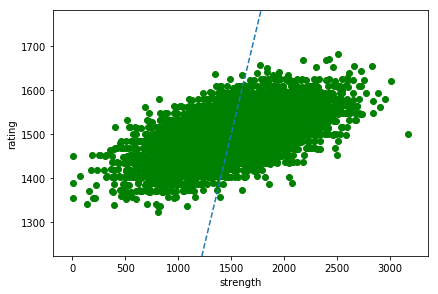

In [622]:
display()

In [615]:
rounds = 60
match_and_update_ratings_elo(rounds)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59


array([[ 9991,  1545,  1492,    15,    15,     1],
       [ 9992,  2051,  1538,    15,    10,     4],
       [ 9993,   829,  1417,     8,    18,     3],
       [ 9994,  1295,  1465,     9,    13,     2],
       [ 9995,  1219,  1520,    13,    10,     0],
       [ 9996,  1051,  1450,     7,    13,     1],
       [ 9997,  1770,  1508,    10,     9,     0],
       [ 9998,  1697,  1498,    13,    13,     2],
       [ 9999,  1472,  1488,    13,    14,     2],
       [10000,  1249,  1489,    11,    12,     4]])


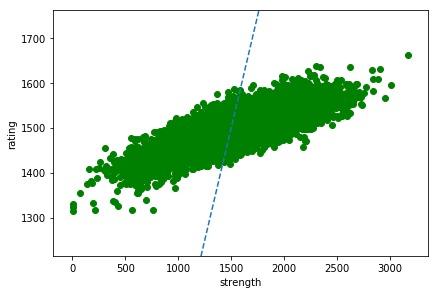

In [617]:
display()

# Glicko2

In [559]:
SIGMA = 0.001
SCALE = 173.7178

In [560]:
def scale_down(user):
    return [(user[2]-1500)/SCALE, user[3]/SCALE]

def scale_up(mu, RD):
    return [SCALE*mu+1500, SCALE*RD]

In [561]:
def g(RD):
    return 1 / math.sqrt(1 + 3*math.pow(RD, 2) / math.pi**2)

def E(mu, muj, RDj):
    return 1 / (1 + math.exp(-1*g(RDj)*(mu-muj)))

def compute_v(mu, muj, RDj):
    expected = E(mu, muj, RDj)
    return 1 / (g(RDj)**2 * expected * (1 - expected))

In [562]:
pprint(scale_down([1, 1500, 1500, 200]))
pprint(scale_down([2, 1400, 1400, 30]))

[0.0, 1.1512924985234674]
[-0.5756462492617337, 0.1726938747785201]


In [563]:
pprint(scale_up(0, 1.1512924985234674))
pprint(scale_up(-0.5756462492617337, 0.1726938747785201))

[1500.0, 200.0]
[1400.0, 30.000000000000004]


In [564]:
g(0.1726938747785201)

0.9954980064506083

In [565]:
E(0, -0.5756462492617337, 0.1726938747785201)

0.6394677305521533

In [566]:
compute_v(0, -0.5756462492617337, 0.1726938747785201)

4.376797309217415

In [567]:
def compute_RD_dash(RD, v):
    RD_star = math.sqrt(RD**2 + SIGMA**2)
    return 1 / math.sqrt(1/(RD_star**2) + 1/v)

def compute_mu_dash(mu, RD_dash, muj, RDj, S):
    return mu + RD_dash**2 * g(RDj) * (S - E(mu, muj, RDj))

In [568]:
compute_RD_dash(1.1512924985234674, compute_v(0, -0.5756462492617337, 0.1726938747785201))

1.0086490034418216

In [569]:
compute_mu_dash(0, 1.0086487113987017, -0.5756462492617337, 0.1726938747785201, 1)

0.36514420538471803

In [570]:
def match_glicko(teamA, teamB):
    S1 = get_score(teamA, teamB)
    S2 = 1 - S1
    
    left = []
    right = []
    
    mu2, RD2 = scale_down(np.average(teamB[:], axis=1))
    for userA in teamA:
        mu1, RD1 = scale_down(userA)
            
        v1 = compute_v(mu1, mu2, RD2)
        RD_dash1 = compute_RD_dash(RD1, v1)
        mu_dash1 = compute_mu_dash(mu1, RD_dash1, mu2, RD2, S1)
        
        left.append(scale_up(mu_dash1, RD_dash1))

    mu1, RD1 = scale_down(np.average(teamA[:], axis=1))
    for userB in teamB:
        mu2, RD2 = scale_down(userB)
            
        v2 = compute_v(mu2, mu1, RD1)
        RD_dash2 = compute_RD_dash(RD2, v2)
        mu_dash2 = compute_mu_dash(mu2, RD_dash2, mu1, RD1, S2)
        
        right.append(scale_up(mu_dash2, RD_dash2))
        
    return [S1, S2], left, right

In [571]:
def match_and_update_ratings_glicko(rounds):
    for i in range(rounds):
        print('epoch: ', i)
        enqueue()
        matches = matchmake()
        for users in matches:
            teamA = np.array(users[:4])
            teamB = np.array(users[4:])
            
            scores, left, right = match_glicko(teamA, teamB)
            S1, S2 = scores
            
            for idx, userA in enumerate(teamA):
                aWin = userA[4] + 1 if S1 == 1 else userA[4]
                aLose = userA[5] + 1 if S1 == 0 else userA[5]
                aDraw = userA[6] + 1 if S1 == 0.5 else userA[6]
                
                mu1 = left[idx][0]
                RD1 = left[idx][1]
                
                c.execute("UPDATE users SET rating=?, RD=?, win=?, lose=?, draw=? WHERE id=?", (int(mu1), RD1, aWin, aLose, aDraw, userA[0]))
                conn.commit()
                
            for idx, userB in enumerate(teamB):
                bWin = userB[4] + 1 if S2 == 1 else userB[4]
                bLose = userB[5] + 1 if S2 == 0 else userB[5]
                bDraw = userB[6] + 1 if S2 == 0.5 else userB[6]

                mu2 = right[idx][0]
                RD2 = right[idx][1]
                
                c.execute("UPDATE users SET rating=?, RD=?, win=?, lose=?, draw=? WHERE id=?", (int(mu2), RD2, bWin, bLose, bDraw, userB[0]))
                conn.commit()

In [605]:
init(raw_users)

In [606]:
rounds = 30
match_and_update_ratings_glicko(rounds)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
not found match
[(737, 1356, 671, 290.3572767316065, 0, 3, 0), (2180, 1686, 843, 300.21040468601024, 0, 3, 0), (243, 667, 869, 326.03431471063584, 0, 2, 0), (1439, 1091, 680, 290.8903025950821, 0, 3, 0), (751, 1701, 786, 296.1462436535252, 1, 3, 0), (566, 1248, 726, 295.01250838962426, 0, 3, 0)]
not found match
[(1439, 1091, 680, 290.8903025950821, 0, 3, 0), (566, 1248, 726, 295.01250838962426, 0, 3, 0), (2180, 1686, 843, 300.21040468601024, 0, 3, 0), (751, 1701, 786, 296.1462436535252, 1, 3, 0), (243, 667, 869, 326.03431471063584, 0, 2, 0)]
not found match
[(9410, 2067, 1645, 338.21568676574043, 2, 0, 0), (6858, 1354, 1646, 327.07364741794294, 2, 0, 1), (9436, 2236, 1681, 315.7552672379856, 2, 1, 0), (3206, 1776, 1720, 315.440507266662, 4, 0, 0), (6299, 1808, 1695, 320.5917787042304, 3, 0, 0), (7518, 1678, 1647, 333.1719997306933, 2, 0, 0)]
not found match
[(6858, 1354, 1646, 327.07364741794294, 2, 0, 1), (7518, 1678, 1647, 333.1719997

not found match
[(8221, 1470, 1713, 321.1747400736311, 3, 0, 0), (4337, 1421, 1796, 282.59358232136304, 6, 1, 0), (4289, 1423, 1849, 280.6501705238269, 5, 0, 0), (3670, 1918, 1812, 292.4075845178506, 4, 0, 0), (6184, 1628, 1782, 308.3664207551904, 5, 0, 1), (6156, 1365, 1762, 312.66658086024796, 5, 0, 0), (5996, 1759, 1753, 288.0801779875882, 4, 1, 0)]
not found match
[(5996, 1759, 1753, 288.0801779875882, 4, 1, 0), (6184, 1628, 1782, 308.3664207551904, 5, 0, 1), (3670, 1918, 1812, 292.4075845178506, 4, 0, 0), (4289, 1423, 1849, 280.6501705238269, 5, 0, 0), (4337, 1421, 1796, 282.59358232136304, 6, 1, 0), (6156, 1365, 1762, 312.66658086024796, 5, 0, 0), (9729, 1381, 1920, 296.4235050954013, 5, 0, 0)]
not found match
[(6156, 1365, 1762, 312.66658086024796, 5, 0, 0), (4337, 1421, 1796, 282.59358232136304, 6, 1, 0), (3670, 1918, 1812, 292.4075845178506, 4, 0, 0), (6184, 1628, 1782, 308.3664207551904, 5, 0, 1), (4289, 1423, 1849, 280.6501705238269, 5, 0, 0), (9729, 1381, 1920, 296.42350509

epoch:  20
not found match
[(512, 764, 208, 224.99814867187598, 0, 7, 0), (1417, 603, 322, 242.60495270289047, 0, 6, 0)]
not found match
[(1417, 603, 322, 242.60495270289047, 0, 6, 0), (2281, 404, 439, 229.1315549841749, 0, 8, 0), (348, 1578, 494, 255.96185822942158, 0, 5, 0), (258, 573, 478, 220.34808360621466, 1, 5, 0), (3207, 1337, 518, 215.13699299767143, 1, 8, 1)]
not found match
[(1467, 1811, 1761, 307.19924880066236, 5, 0, 1), (3863, 2152, 1894, 290.0803576114828, 6, 0, 0), (3670, 1918, 1812, 292.4075845178506, 4, 0, 0), (7806, 1855, 1887, 298.6425256895983, 5, 0, 0), (5685, 1707, 1796, 315.08803250449455, 4, 0, 0), (5690, 1890, 1931, 295.0054846023558, 8, 0, 1)]
not found match
[(5685, 1707, 1796, 315.08803250449455, 4, 0, 0), (3863, 2152, 1894, 290.0803576114828, 6, 0, 0), (3670, 1918, 1812, 292.4075845178506, 4, 0, 0), (7806, 1855, 1887, 298.6425256895983, 5, 0, 0), (5690, 1890, 1931, 295.0054846023558, 8, 0, 1)]
not found match
[(3670, 1918, 1812, 292.4075845178506, 4, 0, 0)

not found match
[(80, 2536, 1783, 290.1917823934019, 7, 1, 1), (4715, 2114, 1906, 295.50485684197093, 9, 0, 0), (4429, 2318, 1930, 270.79374450947597, 11, 1, 1), (6095, 1844, 1785, 290.10878730809276, 6, 1, 1), (5832, 2188, 1790, 288.01031741899493, 6, 1, 0)]
not found match
[(6095, 1844, 1785, 290.10878730809276, 6, 1, 1), (5832, 2188, 1790, 288.01031741899493, 6, 1, 0), (4429, 2318, 1930, 270.79374450947597, 11, 1, 1), (4715, 2114, 1906, 295.50485684197093, 9, 0, 0)]
not found match
[(5832, 2188, 1790, 288.01031741899493, 6, 1, 0), (6959, 1989, 1989, 290.6331621161831, 8, 0, 0), (4429, 2318, 1930, 270.79374450947597, 11, 1, 1), (4715, 2114, 1906, 295.50485684197093, 9, 0, 0)]
not found match
[(4715, 2114, 1906, 295.50485684197093, 9, 0, 0), (6959, 1989, 1989, 290.6331621161831, 8, 0, 0), (4429, 2318, 1930, 270.79374450947597, 11, 1, 1)]
not found match
[(4429, 2318, 1930, 270.79374450947597, 11, 1, 1), (6959, 1989, 1989, 290.6331621161831, 8, 0, 0)]
not found match
[(6959, 1989, 1989

array([[ 9991,  1545,  1544,     8,     5,     0],
       [ 9992,  2051,  1542,     2,     1,     1],
       [ 9993,   829,  1337,     2,     3,     0],
       [ 9994,  1295,  1154,     3,     6,     0],
       [ 9995,  1219,  1142,     2,     4,     1],
       [ 9996,  1051,  1128,     2,     7,     0],
       [ 9997,  1770,  1086,     7,     9,     1],
       [ 9998,  1697,  1360,     5,     4,     1],
       [ 9999,  1472,  1612,     3,     2,     0],
       [10000,  1249,  1318,     4,     5,     0]])


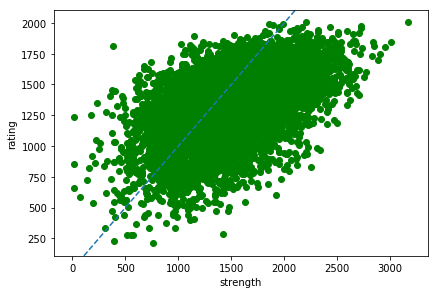

In [607]:
display()

In [608]:
rounds = 60
match_and_update_ratings_glicko(rounds)

epoch:  0
not found match
[(638, 1419, 284, 216.9776741782105, 0, 6, 0), (9425, 710, 457, 197.10497439766272, 1, 12, 0), (373, 311, 331, 230.45323795570232, 1, 8, 0), (151, 950, 436, 185.93231610475507, 3, 10, 0), (2779, 371, 476, 219.92511146693658, 0, 8, 1), (5071, 1143, 406, 210.4149376387983, 1, 10, 0), (83, 677, 421, 222.44703915654398, 1, 8, 0)]
not found match
[(9737, 2312, 1817, 275.6070371464738, 9, 3, 0), (4441, 1649, 1888, 269.91225348503446, 9, 2, 1), (4429, 2318, 1930, 270.79374450947597, 11, 1, 1), (5984, 2329, 1848, 295.14766782417126, 8, 1, 1), (8693, 2012, 1855, 301.99203611589195, 7, 0, 0), (5592, 2309, 1883, 269.40720468458346, 9, 2, 0), (9530, 2201, 2006, 283.4866375820329, 10, 0, 0)]
not found match
[(5984, 2329, 1848, 295.14766782417126, 8, 1, 1), (5592, 2309, 1883, 269.40720468458346, 9, 2, 0), (4429, 2318, 1930, 270.79374450947597, 11, 1, 1), (4441, 1649, 1888, 269.91225348503446, 9, 2, 1), (9530, 2201, 2006, 283.4866375820329, 10, 0, 0), (8693, 2012, 1855, 301.

epoch:  8
not found match
[(258, 573, 234, 171.4770535312818, 1, 10, 0), (83, 677, 322, 203.7725702564662, 2, 10, 0), (544, 971, 336, 204.4983449849633, 1, 7, 1), (847, 648, 434, 238.4506958946858, 1, 10, 0), (2045, 555, 347, 183.74473141651364, 1, 9, 1), (638, 1419, 340, 193.72201888403782, 1, 7, 0), (715, 669, 303, 190.4014355811304, 3, 11, 0)]
not found match
[(83, 677, 322, 203.7725702564662, 2, 10, 0), (770, 1109, 488, 182.8547192376816, 4, 10, 0), (638, 1419, 340, 193.72201888403782, 1, 7, 0)]
not found match
[(638, 1419, 340, 193.72201888403782, 1, 7, 0), (770, 1109, 488, 182.8547192376816, 4, 10, 0), (1136, 439, 524, 203.77303103893905, 1, 11, 0), (2956, 922, 527, 203.75000123745556, 1, 8, 2), (6255, 879, 528, 177.6959967606916, 4, 12, 1), (8201, 1040, 529, 224.57549113320036, 1, 10, 0)]
not found match
[(8693, 2012, 1845, 292.2892845439582, 9, 1, 0), (6680, 2676, 1851, 257.2453608789939, 11, 3, 2), (9394, 2523, 1985, 281.62890584744594, 10, 0, 0), (8004, 1798, 1846, 293.440282

not found match
[(5540, 2058, 1813, 256.4468942914747, 9, 2, 2), (5690, 1890, 2003, 258.18560711198296, 13, 2, 2), (4460, 1953, 1955, 249.65847443792447, 12, 2, 1), (978, 2212, 1971, 257.01355874748, 12, 1, 0), (6129, 1716, 1923, 267.8281789904226, 9, 2, 3), (9584, 2188, 1873, 246.00626663362817, 13, 3, 2), (4351, 1872, 1903, 260.2557588568374, 12, 2, 2)]
not found match
[(9584, 2188, 1873, 246.00626663362817, 13, 3, 2), (4460, 1953, 1955, 249.65847443792447, 12, 2, 1), (5690, 1890, 2003, 258.18560711198296, 13, 2, 2), (6129, 1716, 1923, 267.8281789904226, 9, 2, 3), (978, 2212, 1971, 257.01355874748, 12, 1, 0), (4351, 1872, 1903, 260.2557588568374, 12, 2, 2)]
not found match
[(4351, 1872, 1903, 260.2557588568374, 12, 2, 2), (978, 2212, 1971, 257.01355874748, 12, 1, 0), (5690, 1890, 2003, 258.18560711198296, 13, 2, 2), (6129, 1716, 1923, 267.8281789904226, 9, 2, 3), (4460, 1953, 1955, 249.65847443792447, 12, 2, 1)]
not found match
[(6129, 1716, 1923, 267.8281789904226, 9, 2, 3), (5690, 

not found match
[(7302, 1888, 1768, 263.6739383335516, 9, 4, 0), (1068, 2167, 1886, 244.63229762239675, 11, 2, 1), (7515, 2171, 1805, 264.4634600580978, 12, 2, 1), (9410, 2067, 1854, 279.59926145322953, 8, 3, 1), (687, 1506, 1774, 253.5918324703826, 11, 3, 3), (8615, 2143, 1897, 243.95894959473563, 12, 3, 1)]
not found match
[(3748, 3012, 1972, 272.3572700845939, 10, 0, 0), (7806, 1855, 2029, 249.39191239784486, 9, 1, 2), (7256, 2490, 1997, 250.05381243843507, 11, 1, 1), (7380, 2724, 2071, 255.66471350641325, 12, 1, 1), (8716, 2371, 1984, 240.81127219956002, 15, 3, 0), (3908, 2215, 2007, 241.40944698116897, 12, 1, 3)]
not found match
[(8716, 2371, 1984, 240.81127219956002, 15, 3, 0), (7380, 2724, 2071, 255.66471350641325, 12, 1, 1), (7806, 1855, 2029, 249.39191239784486, 9, 1, 2), (7256, 2490, 1997, 250.05381243843507, 11, 1, 1), (3908, 2215, 2007, 241.40944698116897, 12, 1, 3)]
not found match
[(7256, 2490, 1997, 250.05381243843507, 11, 1, 1), (7806, 1855, 2029, 249.39191239784486, 9,

not found match
[(8953, 1550, 1772, 268.7021862846707, 9, 2, 3), (23, 1932, 1877, 250.95111990848386, 12, 2, 3), (7211, 2321, 1831, 233.20334892374902, 16, 5, 1), (4008, 2207, 1775, 244.59065440130257, 10, 6, 1), (4429, 2318, 1810, 258.77613572071255, 12, 5, 1)]
not found match
[(4008, 2207, 1775, 244.59065440130257, 10, 6, 1), (7211, 2321, 1831, 233.20334892374902, 16, 5, 1), (23, 1932, 1877, 250.95111990848386, 12, 2, 3), (4429, 2318, 1810, 258.77613572071255, 12, 5, 1)]
not found match
[(4429, 2318, 1810, 258.77613572071255, 12, 5, 1), (5690, 1890, 2003, 258.18560711198296, 13, 2, 2), (9530, 2201, 1983, 254.9615747387523, 15, 3, 1), (7211, 2321, 1831, 233.20334892374902, 16, 5, 1), (9603, 2705, 2006, 274.9774387779742, 10, 0, 1), (978, 2212, 1991, 255.2766145919149, 13, 1, 0), (23, 1932, 1877, 250.95111990848386, 12, 2, 3)]
not found match
[(978, 2212, 1991, 255.2766145919149, 13, 1, 0), (1700, 2651, 2045, 257.34653474205373, 14, 1, 0), (5690, 1890, 2003, 258.18560711198296, 13, 2, 

not found match
[(2464, 1758, 1805, 211.89300880240793, 13, 5, 0), (4273, 2082, 1830, 211.54385909105468, 16, 2, 3), (1074, 2136, 1971, 272.33656975501043, 11, 1, 0), (8280, 2081, 1954, 237.4898395531854, 10, 3, 1), (7490, 2220, 1969, 273.13349872861147, 11, 2, 1)]
not found match
[(9900, 2540, 2032, 271.14549732017764, 12, 0, 1), (9193, 2843, 2047, 263.90769628918275, 13, 2, 0), (3908, 2215, 2035, 239.540430871566, 13, 1, 3)]
not found match
[(3908, 2215, 2035, 239.540430871566, 13, 1, 3), (9193, 2843, 2047, 263.90769628918275, 13, 2, 0)]
not found match
[(9193, 2843, 2047, 263.90769628918275, 13, 2, 0)]
epoch:  33
not found match
[(926, 390, 169, 203.89871014112592, 0, 10, 0), (8045, 1041, 293, 156.09079660857344, 3, 15, 0)]
not found match
[(6039, 1870, 1777, 224.91090547473163, 15, 6, 1), (3658, 2532, 1969, 249.74190208375563, 14, 2, 1), (2998, 2167, 1800, 269.1141092824106, 12, 2, 1), (6680, 2676, 1963, 240.3067972970707, 16, 3, 3)]
not found match
[(2998, 2167, 1800, 269.11410928

not found match
[(1130, 2091, 1782, 235.5715431591443, 14, 5, 2), (1156, 1844, 1965, 234.6222552168231, 15, 3, 1), (6785, 2185, 1964, 234.77803550848387, 14, 4, 0)]
not found match
[(6785, 2185, 1964, 234.77803550848387, 14, 4, 0), (978, 2212, 2023, 249.89607286639017, 15, 2, 0), (9193, 2843, 2047, 263.90769628918275, 13, 2, 0), (3658, 2532, 2034, 241.24514931589138, 16, 2, 1), (1700, 2651, 2076, 255.49333651198097, 15, 1, 0), (1156, 1844, 1965, 234.6222552168231, 15, 3, 1)]
not found match
[(1156, 1844, 1965, 234.6222552168231, 15, 3, 1), (1700, 2651, 2076, 255.49333651198097, 15, 1, 0), (978, 2212, 2023, 249.89607286639017, 15, 2, 0), (3658, 2532, 2034, 241.24514931589138, 16, 2, 1), (9193, 2843, 2047, 263.90769628918275, 13, 2, 0)]
not found match
[(978, 2212, 2023, 249.89607286639017, 15, 2, 0), (3658, 2532, 2034, 241.24514931589138, 16, 2, 1), (1700, 2651, 2076, 255.49333651198097, 15, 1, 0), (9193, 2843, 2047, 263.90769628918275, 13, 2, 0)]
not found match
[(3658, 2532, 2034, 241

not found match
[(2199, 1885, 1754, 236.25105045722353, 9, 3, 2), (3540, 1892, 1761, 224.99932675620107, 15, 4, 1), (3840, 1998, 1889, 243.82192105686784, 12, 3, 1), (5625, 2336, 1847, 230.79218574177085, 18, 5, 2), (9664, 2481, 1802, 221.30295570317776, 19, 5, 1), (511, 1815, 1947, 224.0992661720419, 17, 4, 1), (5968, 2487, 1910, 210.9189914580451, 19, 5, 2)]
not found match
[(3540, 1892, 1761, 224.99932675620107, 15, 4, 1), (9664, 2481, 1802, 221.30295570317776, 19, 5, 1), (3840, 1998, 1889, 243.82192105686784, 12, 3, 1), (5968, 2487, 1910, 210.9189914580451, 19, 5, 2), (5625, 2336, 1847, 230.79218574177085, 18, 5, 2), (511, 1815, 1947, 224.0992661720419, 17, 4, 1)]
not found match
[(9664, 2481, 1802, 221.30295570317776, 19, 5, 1), (7156, 2144, 1972, 238.87677198327015, 18, 3, 0), (5968, 2487, 1910, 210.9189914580451, 19, 5, 2), (511, 1815, 1947, 224.0992661720419, 17, 4, 1), (3840, 1998, 1889, 243.82192105686784, 12, 3, 1), (3896, 2433, 2002, 230.86135715316598, 17, 4, 1), (5625, 23

not found match
[(9866, 2391, 1944, 247.1194314864418, 16, 1, 1), (7490, 2220, 2057, 263.93774299903936, 14, 2, 1), (7380, 2724, 2045, 244.02071023381293, 15, 2, 1), (1074, 2136, 1995, 269.8285874594041, 12, 1, 0), (9530, 2201, 2062, 243.58871826038657, 18, 3, 1)]
not found match
[(1074, 2136, 1995, 269.8285874594041, 12, 1, 0), (9530, 2201, 2062, 243.58871826038657, 18, 3, 1), (7490, 2220, 2057, 263.93774299903936, 14, 2, 1), (7380, 2724, 2045, 244.02071023381293, 15, 2, 1)]
not found match
[(7380, 2724, 2045, 244.02071023381293, 15, 2, 1), (7490, 2220, 2057, 263.93774299903936, 14, 2, 1), (9530, 2201, 2062, 243.58871826038657, 18, 3, 1)]
not found match
[(7490, 2220, 2057, 263.93774299903936, 14, 2, 1), (9530, 2201, 2062, 243.58871826038657, 18, 3, 1)]
not found match
[(9530, 2201, 2062, 243.58871826038657, 18, 3, 1)]
epoch:  51
not found match
[(258, 573, 172, 160.62663968741828, 1, 11, 0), (8721, 10, 354, 170.87285860518924, 3, 19, 1), (7913, 371, 349, 155.62859961089768, 3, 22, 1)

not found match
[(796, 519, 210, 159.61096812883932, 2, 11, 0), (2684, 539, 381, 153.25702109622492, 7, 21, 0), (6548, 251, 371, 199.57490386626415, 2, 18, 1), (1214, 703, 407, 156.22715594433413, 4, 19, 1), (810, 156, 328, 162.4496390305363, 3, 18, 1)]
not found match
[(8514, 1815, 1755, 208.7070238310847, 18, 8, 3), (8244, 1781, 1905, 222.39653222879818, 21, 8, 0), (6803, 1949, 1845, 254.672474011059, 13, 4, 3), (7615, 2666, 1776, 212.44377821079, 18, 5, 5), (5313, 2591, 1860, 235.506873032939, 16, 6, 2), (6049, 2151, 1888, 222.60560161268668, 15, 4, 1), (8164, 1776, 1760, 221.46530508402267, 15, 6, 3)]
not found match
[(8164, 1776, 1760, 221.46530508402267, 15, 6, 3), (6049, 2151, 1888, 222.60560161268668, 15, 4, 1), (8244, 1781, 1905, 222.39653222879818, 21, 8, 0), (6803, 1949, 1845, 254.672474011059, 13, 4, 3), (5313, 2591, 1860, 235.506873032939, 16, 6, 2), (7615, 2666, 1776, 212.44377821079, 18, 5, 5)]
not found match
[(7615, 2666, 1776, 212.44377821079, 18, 5, 5), (6803, 1949, 

array([[ 9991,  1545,  1423,    15,    14,     3],
       [ 9992,  2051,  1354,    13,    11,     1],
       [ 9993,   829,  1020,     6,    14,     1],
       [ 9994,  1295,   863,    11,    17,     0],
       [ 9995,  1219,  1206,     8,    12,     2],
       [ 9996,  1051,  1098,     7,    15,     1],
       [ 9997,  1770,  1262,    19,    15,     2],
       [ 9998,  1697,  1081,    11,    18,     3],
       [ 9999,  1472,  1178,    13,    11,     3],
       [10000,  1249,  1146,    12,    14,     1]])


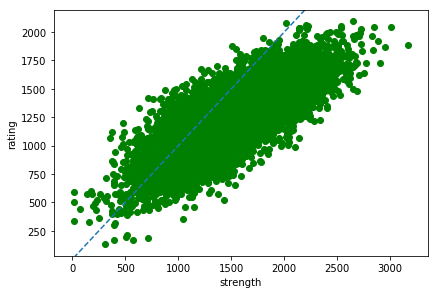

In [609]:
display()